In [1]:
import sys
sys.path.append("../")
sys.path.append('../../../PeptidesDynamicLandscape/scripts/')
import numpy as np
import manage_files as mf
import relaxation_times as rt
import matplotlib.pyplot as plt
import SRT_optimization as srt

/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [2]:
output_path_relax="../../../PeptidesDynamicLandscape/relax_times_yamls/SDS/average_over_SDS/"            # folder to save spin relaxation times yaml files, 
output_path_timescales="../../../PeptidesDynamicLandscape/timescales_yamls/SDS/average_over_SDS/"  # folder to save timescale yaml files
 
relaxation_yamls,timescales_yamls=mf.load_yaml_files(output_path_relax,output_path_timescales)

Spin relaxation data exist for:

   * empty_60SDS_micelle_CHARMM36_OPC_10fsSF_307K_replica1
   * empty_60SDS_Na_DESAmber_TIP4P_293K_10fsSF_replica1
   * GWALP_dimer_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2
   * hMff_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_23500water_replica1
   * empty_60SDS_micelle_CHARMM36_OPC_10fsSF_293K_replica2
   * GWALP_monomer_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * GWALP_monomer_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * empty_60SDS_micelle_CHARMM36_OPC_10fsSF_293K_replica1
   * yFis1_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_replica3
   * hMff_micelle_60SDS_CHARMM_310K_Na_Neut_OPC_replica3
   * empty_60SDS_micelle_CHARMM36_TIP3P_10fsSF_replica2
   * empty_60SDS_Na_DESAmber_TIP4P_293K_replica2_from_whole_charmm
   * hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * hMff_micelle_60SDS_CHARMM_310K_Na_Neut_OPC_replica2
   * GWALP_dimer_micelle_60SDS_CHARMM_310K_Na_Neut_OPC_repli

In [3]:
gammaD=41.695*10**6; #r*s^(-1)*T^(-1)
gammaH=267.513*10**6;
gammaC=67.262*10**6;
gammaN=-27.166*10**6;


magn_field_MHz=850 # for values in MHz
magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6

for i,timescales in enumerate([timescales_yamls]):
    
    eff_times=[]
    R1s=[]
    R2s=[]
    hetNOEs=[]
    
    for sim in timescales:        
        #check if timesales exist
        for ana2 in timescales[sim]:
            info=timescales[sim][ana2]["info"]
            #select the analysis that we used
            if (info["04_smallest_corr_time_[s]"]==10**(-12) and
                info["05_biggest_corr_time_[s]"]==10**(-7) and
                info["03_N_exp_to_fit"]==100 and
                info["00_nuclei"]=='15N'):

                for bond in timescales[sim][ana2]["results"]["Coeff"]:
                    if timescales[sim][ana2]["results"]["Coeff"][bond][-1]>0:
                        timescales[sim][ana2]["results"]["Coeff"][bond][-1]=0
                    
                    coeff=timescales[sim][ana2]["results"]["Coeff"][bond]
                    ctime=timescales[sim][ana2]["results"]["Ctime"]
                    effTime=sum(t*k for t,k in zip(coeff,ctime))*10**9

                    T1,T2,NOE=rt.get_relaxation_D(magnetic_field,coeff,ctime,0)
                    
                    eff_times.append(effTime)
                    R1s.append(1/T1)
                    R2s.append(1/T2)
                    hetNOEs.append(NOE)
    
    
    data_to_save=np.array([eff_times,R1s,R2s,hetNOEs])
    np.savetxt("simulation_SRT_vs_effTime/SDS_micelles_"+str(magn_field_MHz)+"_deutherium.dat",data_to_save)
                    

In [4]:
systems={}

systems['micelles']=np.loadtxt("simulation_SRT_vs_effTime/SDS_micelles_850_deutherium.dat")

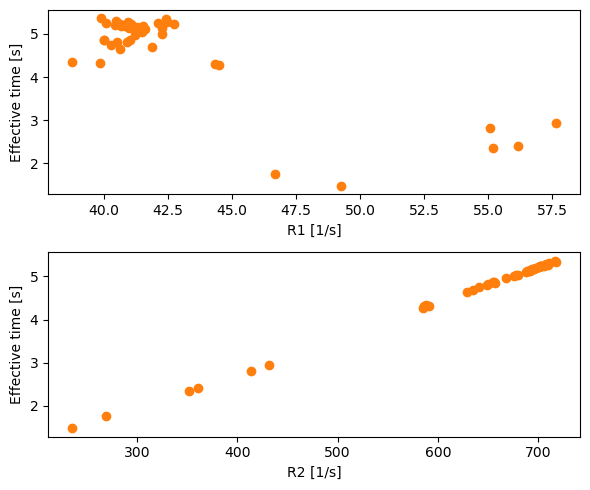

In [6]:
fig, (ax1, ax2) = plt.subplots(2,sharex=False)
plt.rcParams["figure.figsize"] = [6, 5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')




for i,system in enumerate(systems):    
    ax1.plot(systems[system][1],systems[system][0],"o",c="C"+str(1+i))
    ax2.plot(systems[system][2],systems[system][0],"o",c="C"+str(1+i))
    #ax3.plot(systems[system][3],systems[system][0],"o",c="C"+str(1+i))

ax1.set_ylabel('Effective time [s]')
ax2.set_ylabel('Effective time [s]')
ax1.set_xlabel('R1 [1/s]')  
ax2.set_xlabel('R2 [1/s]')  


plt.savefig('SDS.png')

In [35]:
def exp(x,t):
    y=np.exp(-x/t)
    return y

def eq3(x,S2,Tm,Te):
    T=(Te+Tm)/(Te*Tm)
    y=1/5 * (S2*np.exp(-x/Tm)) + 1/5 * (1-S2) * np.exp(-x/T)
    return y, 1/5 * (S2*np.exp(-x/Tm)), 1/5 * (1-S2) * np.exp(-x/T)

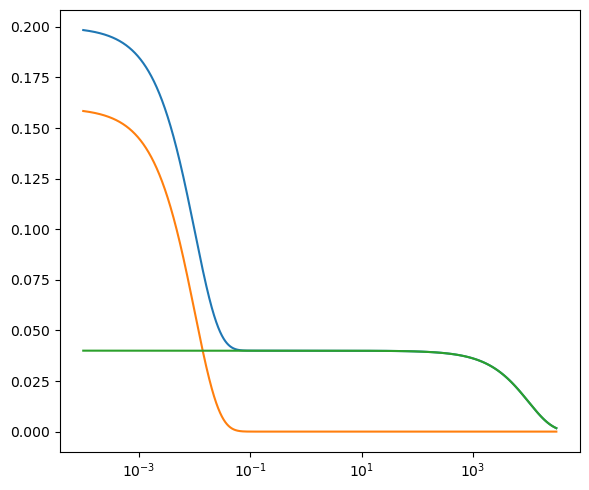

In [92]:
x=np.logspace(-4,4.5,10**5)
#x=np.logspace(-4,-1,10**5)
#x=np.linspace(10**(-5),10**3,10**5)
plt.xscale('log')
#plt.plot(x,0.2*exp(x,10000)+0.5*exp(x,100000)+0.3*exp(x,50000))
plt.plot(x,eq3(x,0.2,10000,100)[0])
plt.plot(x,eq3(x,0.2,10000,100)[2])
plt.plot(x,eq3(x,0.2,10000,100)[1])